# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
#BALLON_WEIGHTS_PATH = "/path/to/mask_rcnn_balloon.h5"  # TODO: update this path

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


## Configurations

In [2]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/balloon")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 0.1, 'rpn_bbox_loss': 0.1, 'inst_id_loss': 1.0, 'mrcnn_bbox_loss': 0.1, 'mrcnn_class_loss': 0.1, 'rpn_class_loss': 0.1}
MASK_POOL_SIZE                 1

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "training"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Training Dataset

In [6]:
# Load validation dataset
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 61
Classes: ['BG', 'balloon']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR,
                              config=config)

KL (None, 1024, 1024) (None, None, None, 6)
(None, None) (None, None, None) (None, None)
(None, 2) (None, None, 4)
(None, None) (None, 2) (None, 4)
KL (None, 1024, 1024) (None, None, None, 6)
(None, None) (None, None, None) (None, None)
(None, 2) (None, None, 4)
(None, None) (None, 2) (None, 4)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image_sub (InputLayer)    (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image_sub[0][0]            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
___________

input_rpn_match_sub (InputLayer (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_rpn_bbox_sub (InputLayer) (None, None, 4)      0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2)            0           input_image_meta_sub[0][0]       
__________________________________________________________________________________________________
input_instance_id_sub (InputLay (None, 1024, 1024)   0                                            
__________________________________________________________________________________________________
mrcnn_class (TimeDistributed)   (None, 200, 2)       0           mrcnn_class_logits[0][0]         
__________________________________________________________________________________________________
output_roi

## Step by Step Prediction

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

In [8]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

NameError: name 'mrcnn' is not defined

In [12]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask, orig_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

image ID: balloon.321888854_3723b6f10b_b.jpg (7) /home/fothar/cluster_segmentation_redesign/datasets/balloon/train/321888854_3723b6f10b_b.jpg


### 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [13]:
def build_batch_data(image, image_meta, gt_class_ids, gt_boxes, gt_masks, gt_orig_masks):
    
    backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
    anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                             config.RPN_ANCHOR_RATIOS,
                                             backbone_shapes,
                                             config.BACKBONE_STRIDES,
                                             config.RPN_ANCHOR_STRIDE)
    
    
    
    rpn_match, rpn_bbox = modellib.build_rpn_targets(image.shape, anchors,
                                                    gt_class_ids, gt_boxes, config)
    inst_ids = modellib.build_kira_targets(image.shape, gt_class_ids, gt_orig_masks, config)
    
    batch_image_meta = np.zeros(
        (1,) + image_meta.shape, dtype=image_meta.dtype)
    batch_rpn_match = np.zeros(
        [1, anchors.shape[0], 1], dtype=rpn_match.dtype)
    batch_rpn_bbox = np.zeros(
        [1, config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4], dtype=rpn_bbox.dtype)
    batch_images = np.zeros(
        (1,) + image.shape, dtype=np.float32)
    batch_gt_class_ids = np.zeros(
        (1, config.MAX_GT_INSTANCES), dtype=np.int32)
    batch_gt_boxes = np.zeros(
        (1, config.MAX_GT_INSTANCES, 4), dtype=np.int32)
    batch_gt_masks = np.zeros(
        (1, gt_masks.shape[0], gt_masks.shape[1],
         config.MAX_GT_INSTANCES), dtype=gt_masks.dtype)
    
    batch_inst_ids = np.zeros(
        (1, image.shape[0], image.shape[1]), dtype=np.int32)
    
    b= 0
    batch_image_meta[b] = image_meta
    batch_rpn_match[b] = rpn_match[:, np.newaxis]
    batch_rpn_bbox[b] = rpn_bbox
    batch_images[b] = modellib.mold_image(image.astype(np.float32), config)
    batch_gt_class_ids[b, :gt_class_ids.shape[0]] = gt_class_ids
    batch_gt_boxes[b, :gt_boxes.shape[0]] = gt_boxes
    batch_gt_masks[b, :, :, :gt_masks.shape[-1]] = gt_masks
    
    batch_inst_ids[b] = inst_ids
    
    inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
                          batch_gt_class_ids, batch_gt_boxes, batch_gt_masks, batch_inst_ids]
    return inputs

In [18]:
from collections import OrderedDict
import keras.backend as K
def run_train_graph(input_batch, outputs, image_metas=None):
    """Runs a sub-set of the computation graph that computes the given
    outputs.
    image_metas: If provided, the images are assumed to be already
        molded (i.e. resized, padded, and normalized)
    outputs: List of tuples (name, tensor) to compute. The tensors are
        symbolic TensorFlow tensors and the names are for easy tracking.
    Returns an ordered dict of results. Keys are the names received in the
    input and values are Numpy arrays.
    """
    keras_model = model.keras_model

    # Organize desired outputs into an ordered dict
    outputs = OrderedDict(outputs)
    for o in outputs.values():
        assert o is not None

    # Build a Keras function to run parts of the computation graph
    inputs = keras_model.inputs
    if keras_model.uses_learning_phase and not isinstance(K.learning_phase(), int):
        inputs += [K.learning_phase()]
    kf = K.function(keras_model.inputs, list(outputs.values()))

    # Prepare inputs
    if image_metas is None:
        print(input_batch[0].shape)
        molded_images, image_metas, _ = model.mold_inputs([input_batch[0][0]])
    else:
        molded_images = images
    image_shape = molded_images[0].shape
    # Anchors
    anchors = model.get_anchors(image_shape)
    # Duplicate across the batch dimension because Keras requires it
    # TODO: can this be optimized to avoid duplicating the anchors?
    anchors = np.broadcast_to(anchors, (model.config.BATCH_SIZE,) + anchors.shape)
    model_in = [molded_images, image_metas, anchors]

    # Run inference
    if keras_model.uses_learning_phase and not isinstance(K.learning_phase(), int):
        model_in.append(0.)
    outputs_np = kf(model_in)

    # Pack the generated Numpy arrays into a a dict and log the results.
    outputs_np = OrderedDict([(k, v)
                              for k, v in zip(outputs.keys(), outputs_np)])
    for k, v in outputs_np.items():
        log(k, v)
    return outputs_np

In [19]:
inputs = build_batch_data(image, image_meta, gt_class_id, gt_bbox, gt_mask, orig_mask)


# Get predictions of mask head
mrcnn = run_train_graph(inputs, [
    ("input_image",        model.keras_model.get_layer("input_image").output)
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

(1, 1024, 1024, 3)


ValueError: Cannot feed value of shape (1, 261888, 4) for Tensor 'input_rpn_match:0', which has shape '(?, ?, 1)'

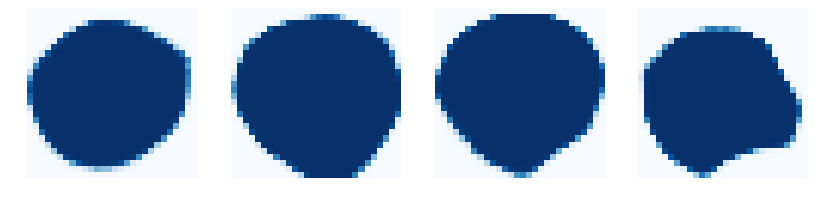

In [30]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

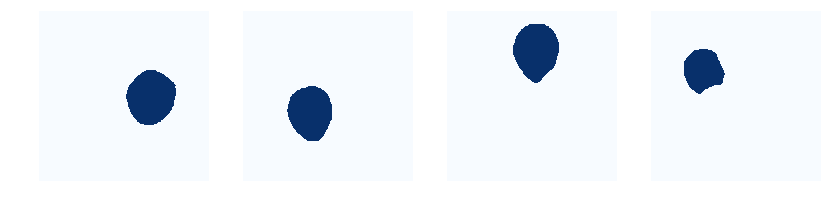

In [31]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [32]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   36.79101  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   34.01261  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   63.39694  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -7.11425  max:  104.21900  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


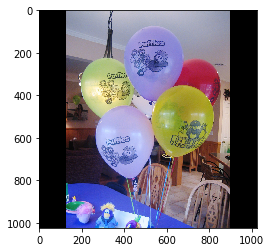

In [33]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

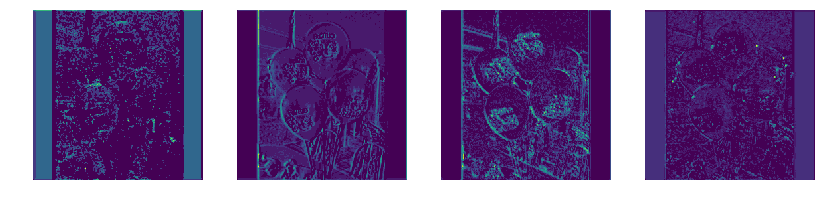

In [34]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)